# Introduction

In this notebook, I analyzed the data about police killings between January and June 2015 in the USA. The data were provided by FiveThirtyEight (https://github.com/fivethirtyeight/data/tree/master/police-killings). They used the Guardian's database and the Census as their sources. Some of the analysis was guided by https://www.dataquest.io.  

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import scipy
from scipy.stats.stats import pearsonr
from scipy.stats import linregress

In [2]:
police_killings = pd.read_csv('police_killings.csv', encoding='ISO-8859-1')
print(police_killings.head())

                 name age gender    raceethnicity     month  day  year  \
0  A'donte Washington  16   Male            Black  February   23  2015   
1      Aaron Rutledge  27   Male            White     April    2  2015   
2         Aaron Siler  26   Male            White     March   14  2015   
3        Aaron Valdez  25   Male  Hispanic/Latino     March   11  2015   
4        Adam Jovicic  29   Male            White     March   19  2015   

            streetaddress          city state    ...     share_hispanic  \
0            Clearview Ln     Millbrook    AL    ...                5.6   
1  300 block Iris Park Dr     Pineville    LA    ...                0.5   
2    22nd Ave and 56th St       Kenosha    WI    ...               16.8   
3       3000 Seminole Ave    South Gate    CA    ...               98.8   
4          364 Hiwood Ave  Munroe Falls    OH    ...                1.7   

   p_income  h_income  county_income  comp_income  county_bucket  nat_bucket  \
0     28375   51367.0   

In [3]:
police_killings.columns

Index(['name', 'age', 'gender', 'raceethnicity', 'month', 'day', 'year',
       'streetaddress', 'city', 'state', 'latitude', 'longitude', 'state_fp',
       'county_fp', 'tract_ce', 'geo_id', 'county_id', 'namelsad',
       'lawenforcementagency', 'cause', 'armed', 'pop', 'share_white',
       'share_black', 'share_hispanic', 'p_income', 'h_income',
       'county_income', 'comp_income', 'county_bucket', 'nat_bucket', 'pov',
       'urate', 'college'],
      dtype='object')

# Diversity in race

Which race did the most victims belong to

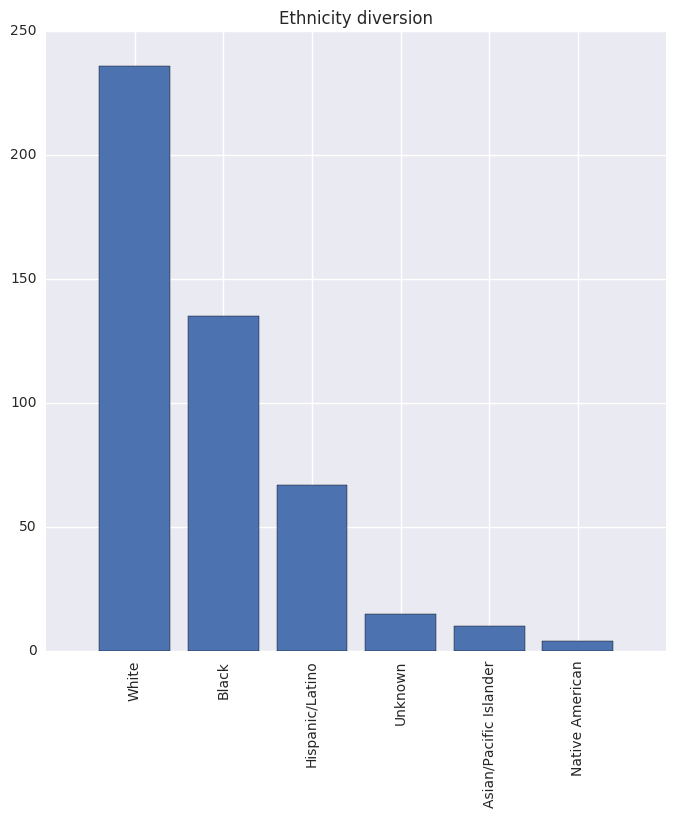

In [76]:
counts = police_killings['raceethnicity'].value_counts()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.bar(range(len(counts)),counts, align='center')
plt.xticks(range(len(counts)),counts.index,rotation='vertical')
plt.title('Ethnicity diversion')
sns.plt.show()

In [5]:
# Share of each group
counts/sum(counts)

White                     0.505353
Black                     0.289079
Hispanic/Latino           0.143469
Unknown                   0.032120
Asian/Pacific Islander    0.021413
Native American           0.008565
Name: raceethnicity, dtype: float64

One can see, more than 50% of the people, who died, were white. 

# Female victims

How many females died.

In [6]:
police_killings['gender'].value_counts()

Male      445
Female     22
Name: gender, dtype: int64

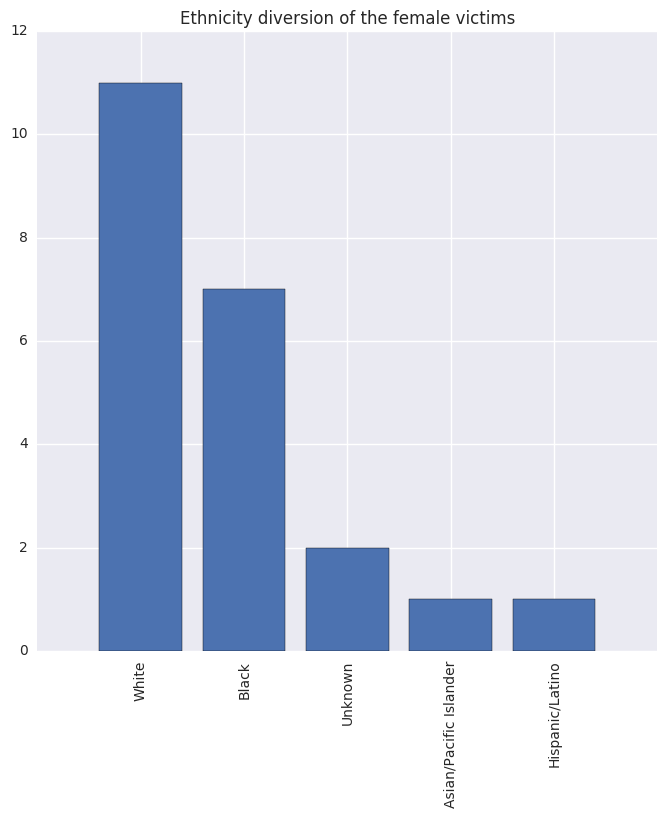

In [77]:
Females = police_killings[police_killings['gender']=='Female']
counts = Females['raceethnicity'].value_counts()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.bar(range(len(counts)),counts, align='center')
plt.xticks(range(len(counts)),counts.index,rotation='vertical')
plt.title('Ethnicity diversion of the female victims')
sns.plt.show()

Only 22 of the victims were female, they were also mostly white.

# Were the victims armed?

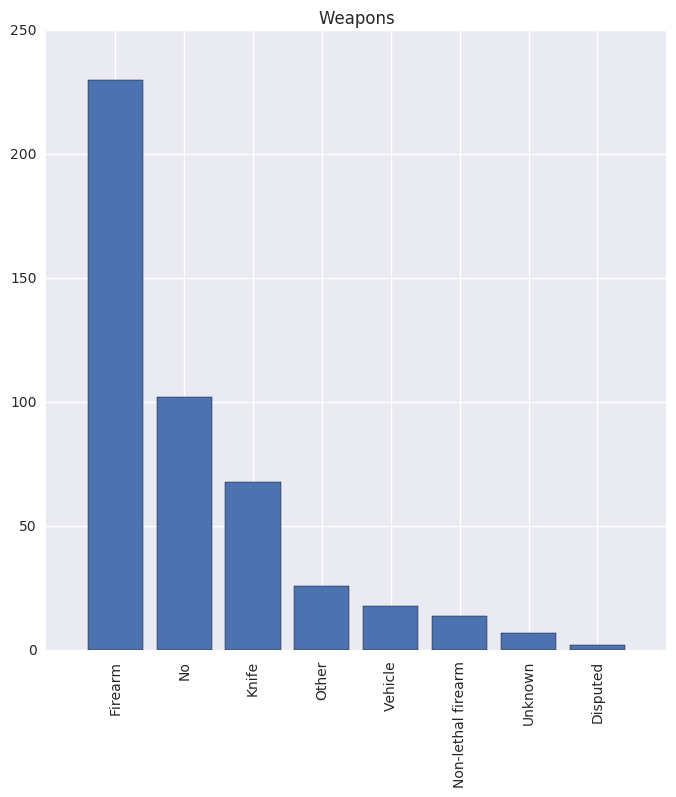

In [78]:
counts = police_killings['armed'].value_counts()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.bar(range(len(counts)),counts,align='center')
plt.xticks(range(len(counts)),counts.index, rotation='vertical')
plt.title('Weapons')
sns.plt.show()

Defining the groups "armed" and "unarmed" in the new column "in_general_armed"

In [9]:
new_series = pd.Series(index=range(0,police_killings.shape[0]))
for i,ele in enumerate(new_series):
    if police_killings['armed'][i] == 'No':
        new_series[i] = 'unarmed'
    elif police_killings['armed'][i] == 'Non-lethal firearm':
        new_series[i] = 'unarmed'
    else:
        new_series[i] = 'armed'
police_killings['in_general_armed'] = new_series

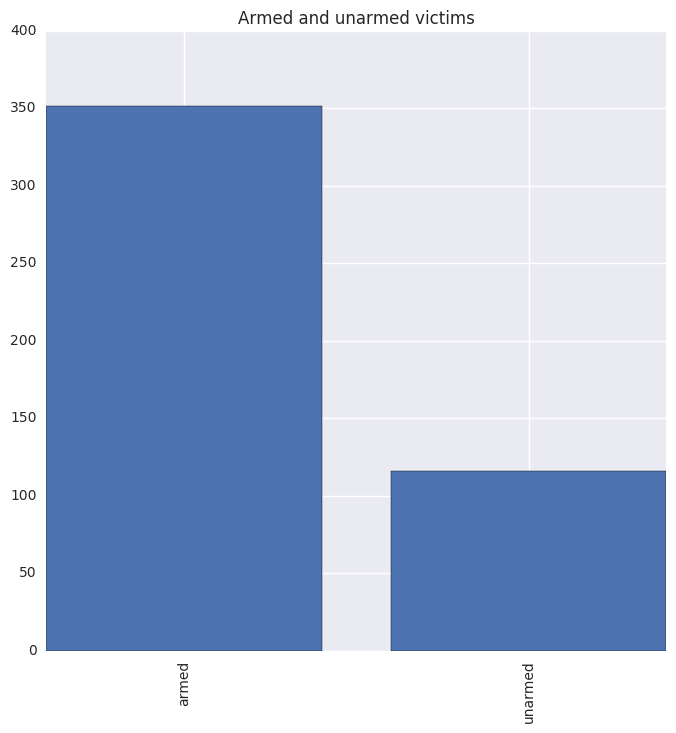

In [79]:
counts = police_killings['in_general_armed'].value_counts()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.bar(range(len(counts)),counts,align='center')
plt.xticks(range(len(counts)),counts.index, rotation='vertical')
plt.title('Armed and unarmed victims')
sns.plt.show()

In [11]:
counts/sum(counts)

armed      0.751606
unarmed    0.248394
Name: in_general_armed, dtype: float64

As one can see, most victims (75%) were actually armed themselves.

# What age-group was mostly victimized?

Defining certain age groups

In [12]:
new_series = pd.Series(index=range(0,police_killings.shape[0]))
for i,ele in enumerate(police_killings['age']):
    if ele == 'Unknown':
        continue
    elif int(ele) <= 10:
        new_series[i] = 'child'
    elif int(ele) <= 18:
        new_series[i] = 'adolescent'
    elif int(ele) <= 60:
        new_series[i] = 'adult'
    elif int(ele) > 60:
        new_series[i] = 'senior'
police_killings['age_group'] = new_series

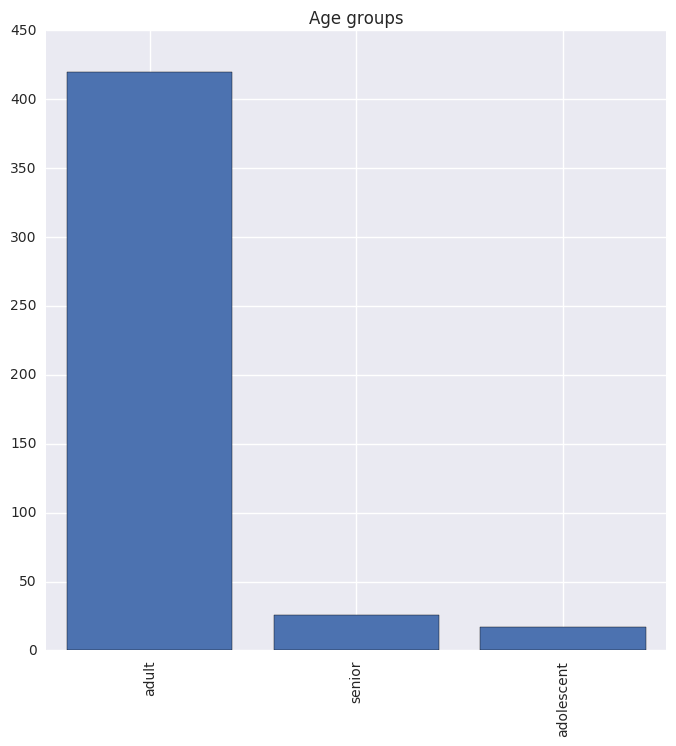

In [80]:
counts = police_killings['age_group'].value_counts()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.bar(range(len(counts)),counts,align='center')
plt.xticks(range(len(counts)),counts.index, rotation='vertical')
plt.title('Age groups')
sns.plt.show()

In [14]:
police_killings[police_killings['age_group']=='adolescent']['in_general_armed'].value_counts()

armed      10
unarmed     7
Name: in_general_armed, dtype: int64

The data set includes no children but 17 teenagers (between 10 and 18 years old). 7 of these were unarmed or possessed a non-lethal firearm.

# Cause of death

In [15]:
police_killings['cause'].value_counts()

Gunshot              411
Taser                 27
Death in custody      14
Struck by vehicle     12
Unknown                3
Name: cause, dtype: int64

Most people are shot to death.

# Shootings by regional personal income and household income

## Personal income

In [16]:
police_killings_changed = police_killings[police_killings['p_income'] != '-']
income = police_killings_changed['p_income'].astype('int64')

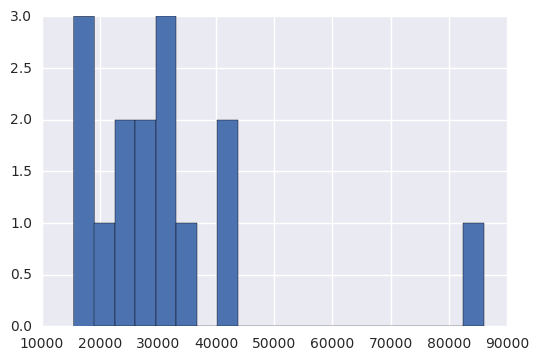

In [70]:
income.hist(bins=20)
sns.plt.show()

In [18]:
police_killings["p_income"][police_killings["p_income"] != "-"].astype(float).median()

22348.0

According to FRED, median personal income in the US is 30,240, and our median is 22,348, which means that shootings tend to happen in less affluent areas. Our sample size is relatively small, though, so it's hard to make sweeping conclusions.

## Household income

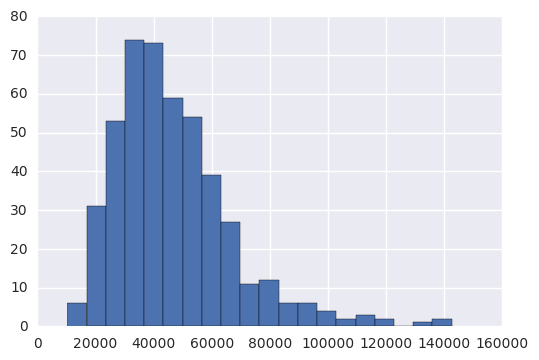

In [71]:
police_killings_changedh = police_killings[np.isnan(police_killings['h_income'])==False]
incomeh = police_killings_changedh['h_income'].astype('int64')
incomeh.hist(bins=20)
sns.plt.show()

In [20]:
police_killings["h_income"][np.isnan(police_killings['h_income'])==False].astype(float).median()

42759.0

According to the census, median income per houshold in 2015 was actually 56,516, although this dataset indicates 42,759. Therefore, this emphasizes the results for the personal income that the shootings happen in less affluent areas. Still the sample size is a bit too small to be sure about this result.

# Shootings by state

Importing data about the state population and calculating how many killings happened per state FIPS code

In [21]:
state_pop = pd.read_csv('state_population.csv')
counts = police_killings['state_fp'].value_counts()

Defining a new dataframe consisting of the state FIPS codes and the value counts

In [22]:
states = pd.DataFrame({'STATE':counts.index, 'shootings': counts})

Introducing the new data frame to the population data frame

In [23]:
states = states.merge(state_pop, on='STATE')
states.head()

,STATE,shootings,SUMLEV,REGION,DIVISION,NAME,POPESTIMATE2015,POPEST18PLUS2015,PCNT_POPEST18PLUS
0,6,74,40,4,9,California,39144818,30023902,76.7
1,48,47,40,3,7,Texas,27469114,20257343,73.7
2,12,29,40,3,5,Florida,20271272,16166143,79.7
3,4,25,40,4,8,Arizona,6828065,5205215,76.2
4,40,22,40,3,7,Oklahoma,3911338,2950017,75.4


Introducting two new columns to the data frame. One, which holds the population sizes in millions and one, which holds the rates of the number of shootings per state, since the states have different sizes.

In [24]:
states["pop_millions"] = states["POPESTIMATE2015"] / 1000000
states['rate'] = states['shootings']/states['pop_millions']

Sort by rate to find the states with the most shootings

In [25]:
states_sorted = states.sort_values('rate',ascending=False)
print(states_sorted.head(5))
print(states_sorted.tail(5))

    STATE  shootings  SUMLEV REGION DIVISION      NAME  POPESTIMATE2015  \
4      40         22      40      3        7  Oklahoma          3911338   
3       4         25      40      4        8   Arizona          6828065   
27     31          6      40      2        4  Nebraska          1896190   
34     15          4      40      4        9    Hawaii          1431603   
39      2          2      40      4        9    Alaska           738432   

    POPEST18PLUS2015  PCNT_POPEST18PLUS  pop_millions      rate  
4            2950017               75.4      3.911338  5.624674  
3            5205215               76.2      6.828065  3.661359  
27           1425853               75.2      1.896190  3.164240  
34           1120770               78.3      1.431603  2.794071  
39            552166               74.8      0.738432  2.708442  
    STATE  shootings  SUMLEV REGION DIVISION           NAME  POPESTIMATE2015  \
29     25          5      40      1        1  Massachusetts          6794

States in the midwest and south seem to have the highest police killing rates, whereas those in the northeast seem to have the lowest.

# State by state differences with focus on highest and lowest shooting rates

Deleting rows, without entries in 'share_white', 'share_black' and 'share_hispanic'

In [26]:
df_without_missing_data = police_killings[(police_killings['share_white'] != '-') & (police_killings['share_black'] != '-') & (police_killings['share_hispanic'] != '-')]
df_without_missing_data.head()

,name,age,gender,raceethnicity,month,day,year,streetaddress,city,state,...,h_income,county_income,comp_income,county_bucket,nat_bucket,pov,urate,college,in_general_armed,age_group
0,A'donte Washington,16,Male,Black,February,23,2015,Clearview Ln,Millbrook,AL,...,51367.0,54766,0.937936,3.0,3.0,14.1,0.097686,0.168510,unarmed,adolescent
1,Aaron Rutledge,27,Male,White,April,2,2015,300 block Iris Park Dr,Pineville,LA,...,27972.0,40930,0.683411,2.0,1.0,28.8,0.065724,0.111402,unarmed,adult
2,Aaron Siler,26,Male,White,March,14,2015,22nd Ave and 56th St,Kenosha,WI,...,45365.0,54930,0.825869,2.0,3.0,14.6,0.166293,0.147312,unarmed,adult
3,Aaron Valdez,25,Male,Hispanic/Latino,March,11,2015,3000 Seminole Ave,South Gate,CA,...,48295.0,55909,0.863814,3.0,3.0,11.7,0.124827,0.050133,armed,adult
4,Adam Jovicic,29,Male,White,March,19,2015,364 Hiwood Ave,Munroe Falls,OH,...,68785.0,49669,1.384868,5.0,4.0,1.9,0.063550,0.403954,unarmed,adult


In [27]:
df_without_missing_data[['share_black','share_white','share_hispanic']] = df_without_missing_data[['share_black','share_white','share_hispanic']].astype('float')

C:\Users\Christiana\Anaconda3\lib\site-packages\pandas\core\frame.py:2378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [28]:
statecounts = police_killings['state'].value_counts()

States with most and least shootings

In [29]:
highest_shooting = statecounts.index[0:10].tolist()
lowest_shooting = statecounts.index[37:48].tolist()


Rows of police_killings, which correspond to the states in highest_shooting and lowest_shooting

In [30]:
df_highest_shooting = df_without_missing_data[df_without_missing_data['state'].isin(highest_shooting)]
df_lowest_shooting = df_without_missing_data[df_without_missing_data['state'].isin(lowest_shooting)]

Calculating the mean of the fractions of white, black and hispanic people in the states with the highest and lowest shooting rates

In [31]:
df_highest_shooting[['share_white','share_black','share_hispanic']].mean()

share_white       44.648846
share_black       14.271538
share_hispanic    31.566538
dtype: float64

In [32]:
df_lowest_shooting[['share_white','share_black','share_hispanic']].mean()

share_white       72.173333
share_black        9.306667
share_hispanic     7.073333
dtype: float64

It looks like the states with low rates of shootings tend to have a lower proportion of blacks in the population, and a lower proportion of hispanics in the census regions where the shootings occur. 
States with high rates of shootings tend to have high hispanic population shares in the counties where shootings occur. Still, as already shown, more black people die, than hispanic.

## Data visualization

It is needed to convert the longitude and latitude values of the shootings to cartesian coordinates in order to display them on a 2D-map

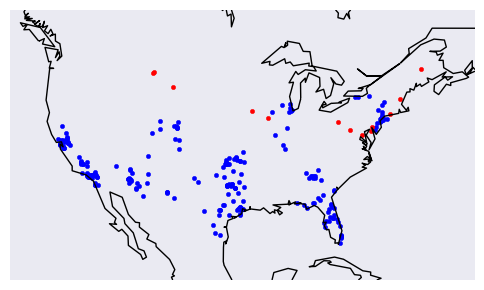

In [81]:
m = Basemap(projection='merc', llcrnrlat=20, urcrnrlat=52, llcrnrlon=-130, urcrnrlon=-60)
longitudes1 = df_highest_shooting["longitude"].tolist()
latitudes1 = df_highest_shooting["latitude"].tolist()
longitudes2 = df_lowest_shooting["longitude"].tolist()
latitudes2 = df_lowest_shooting["latitude"].tolist()
x1, y1 = m(longitudes1, latitudes1)
x2, y2 = m(longitudes2, latitudes2)
m.scatter(x1, y1, s=10,color='blue')
m.scatter(x2, y2, s=10,color='red')
m.drawcoastlines()
sns.plt.show()

The blue dots represent the shootings in the states with the most shooting rates, the red dots represent the states with the least shootings.

## Personal income

Personal income in states with highest and lowest shooting rates.

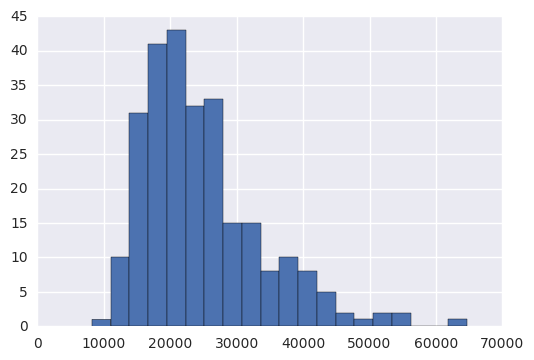

In [72]:
df_highest_shooting_income = df_highest_shooting[df_highest_shooting['p_income'] != '-']
income = df_highest_shooting_income['p_income'].astype('int64')
income.hist(bins=20)
sns.plt.show()

In [35]:
df_highest_shooting["p_income"][df_highest_shooting["p_income"] != "-"].astype(float).median()

22783.5

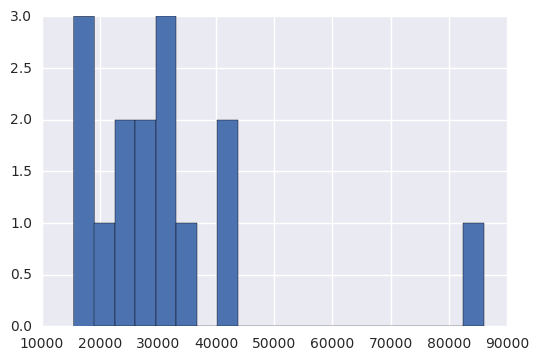

In [73]:
df_lowest_shooting_income = df_lowest_shooting[df_lowest_shooting['p_income'] != '-']
income = df_lowest_shooting_income['p_income'].astype('int64')
income.hist(bins=20)
sns.plt.show()

In [37]:
df_lowest_shooting["p_income"][df_lowest_shooting["p_income"] != "-"].astype(float).median()

28125.0

It looks like the income of the states, where most shootings occur, is much lower.

## Poverty, college education and unemployment rates

In [38]:
df_without_missing_data[['pov']] = df_without_missing_data[['pov']].astype('float')

C:\Users\Christiana\Anaconda3\lib\site-packages\pandas\core\frame.py:2378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [39]:
pivottable = df_without_missing_data.pivot_table(index="state", values=["pov",'urate','college'], aggfunc=np.mean)
pivottable.head()

,college,pov,urate
state,,,
AK,0.215967,19.300000,0.112907
AL,0.273958,16.512500,0.089344
AR,0.163693,22.325000,0.089966
AZ,0.213350,23.572000,0.122033
CA,0.228564,20.494595,0.126445


In [40]:
pov_highest_shooting = pivottable.loc[highest_shooting]
pov_lowest_shooting = pivottable.loc[lowest_shooting]

In [41]:
pov_highest_shooting.mean()

college     0.225342
pov        20.602706
urate       0.115839
dtype: float64

In [42]:
pov_lowest_shooting.mean()

college     0.289182
pov        14.065000
urate       0.089489
dtype: float64

As one can see, poverty and unemployment rates are much higher in states, where most shootings occur, than in states were the least shootings occus. Moreover, more people attended colleage in states with less shootings. 

# Poverty and unemployment rates per city

In [43]:
pov_city = df_without_missing_data.pivot_table(index="city", values=["pov",'urate','college'], aggfunc=np.mean)
pov_city.head()

,college,pov,urate
city,,,
Albany,0.138646,44.50,0.125672
Albuquerque,0.335281,16.55,0.063614
Allentown,0.193037,11.30,0.072277
Aloha,0.174887,8.80,0.135548
Alpine,0.227393,19.20,0.090909


Analyzing the correlations between poverty, unemployment rate and college education.

<function matplotlib.pyplot.show>

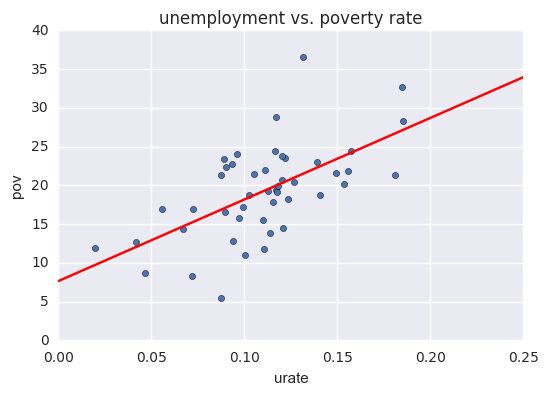

In [82]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pivottable['urate'],pivottable['pov'])
predict_pov = 0*slope+intercept
predict_pov2 = 0.25*slope+intercept
pivottable.plot('urate','pov',kind='scatter',title='unemployment vs. poverty rate',xlim=(0,0.25))
plt.plot([0,0.25],[predict_pov,predict_pov2],color='r')
sns.plt.show

<function matplotlib.pyplot.show>

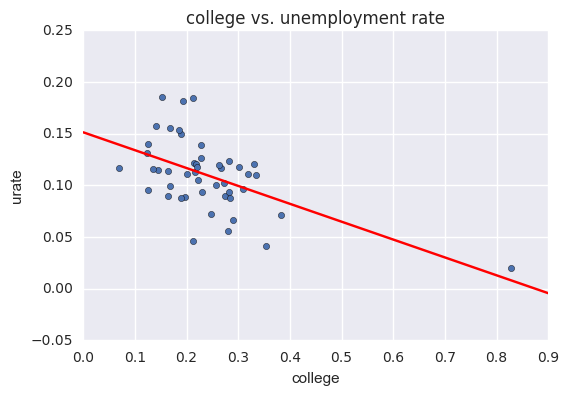

In [83]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pivottable['college'],pivottable['urate'])
predict_pov = 0*slope+intercept
predict_pov2 = 0.9*slope+intercept
pivottable.plot('college','urate',kind='scatter',title='college vs. unemployment rate',xlim=(0,0.9))
plt.plot([0,0.9],[predict_pov,predict_pov2],color='r')
sns.plt.show

<function matplotlib.pyplot.show>

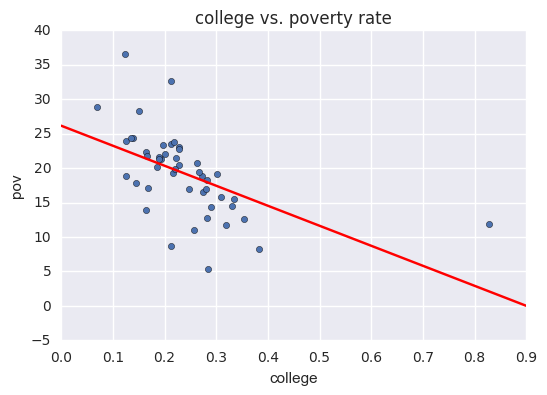

In [84]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pivottable['college'],pivottable['pov'])
predict_pov = 0*slope+intercept
predict_pov2 = 0.9*slope+intercept
pivottable.plot('college','pov',kind='scatter',title='college vs. poverty rate',xlim=(0,0.9))
plt.plot([0,0.9],[predict_pov,predict_pov2],color='r')
sns.plt.show

In [47]:
print('Pearson residuals')
r, p_value = pearsonr(pov_city['urate'],pov_city['pov'])
print('unemployment vs. poverty:', r)

r, p_value = pearsonr(pov_city['college'],pov_city['urate'])
print('college vs. unemployment:', r)

r, p_value = pearsonr(pov_city['college'],pov_city['pov'])
print('college vs. poverty:', r)

Pearson residuals
unemployment vs. poverty: 0.603048295291
college vs. unemployment: -0.451138199053
college vs. poverty: -0.472430465352


As expected, the unemployment rate, the poverty rate and the college attendees rate are highly correlated. The lower the number of college attendees, the higher the poverty and unemployment rate. The higher the unemployment rate, the higher the poverty.